In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import scanpy as sc
import decoupler as dc
import pathlib

from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

sc.settings.verbosity = 3         
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.23.5 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:202: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(
/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:302: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(


In [38]:
%cd /home/orimosko/projects/phago/invitro

/home/orimosko/projects/phago/invitro


In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
PHAGO_COLOR = "#FF97E2"
NONPHAGO_COLOR = "#00A86B"

In [4]:
sys.version

'3.8.19 (default, Mar 20 2024, 19:58:24) \n[GCC 11.2.0]'

In [5]:
sc.settings.figdir = pathlib.PosixPath("plots/")

In [6]:
adata = sc.read_h5ad('/mc_disk2/data/h5ads/phago/invitro_qc.h5ad')

In [11]:
adata.obs[['Time_point', 'Replicate', 'Cell_type']].value_counts(sort=False)

Time_point  Replicate  Cell_type     
3           2          non-phago-macs     257
                       phago              347
            3          non-phago-macs     587
                       phago              893
            4          non-phago-macs     974
                       phago              807
24          2          non-phago-macs     461
                       phago              551
            3          non-phago-macs     748
                       phago             1153
            4          non-phago-macs    1309
                       phago              628
Name: count, dtype: int64

In [12]:
adata.shape

(8715, 24337)

In [13]:
adata.raw = adata

In [14]:
adata.layers["counts"] = adata.X.copy()

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.filter_genes(adata, min_cells=100)

filtered out 15250 genes that are detected in less than 100 cells


In [18]:
#adata.X = adata.X.todense()

In [19]:
sc.pp.combat(adata, 'Replicate', covariates=['Time_point', 'Cell_type'])

Standardizing Data across genes.

Found 3 batches

Found 2 categorical variables:
	Time_point, Cell_type

Found 0 numerical variables:
	



Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



In [20]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X

In [30]:
bad_genes = adata.var_names[(adata.var_names.str.startswith('mt-') |
                             adata.var_names.str.startswith('Gm') |
                             adata.var_names.str.startswith('Rps') |
                             adata.var_names.str.startswith('Rpl') |
                             adata.var_names.str.contains('-ps') |
                             adata.var_names.str.endswith('Rik') |
                             adata.var_names.str.endswith('Rik2') |
                             adata.var_names.str.endswith('Rik8')
                            )]

In [31]:
bad_genes = bad_genes.tolist() + ['Rn18s-rs5']

In [32]:
adata = adata[:, ~adata.var_names.isin(bad_genes)]

In [35]:
adata

AnnData object with n_obs × n_vars = 8715 × 8425
    obs: 'Amp.Batch.ID', 'Well_position', 'Seq.Batch.ID', 'Date of sequencing', 'Batch.Set.ID', 'Owner', 'Date of sort', 'Plate description', 'Empty_well', 'Species', 'Genome', 'Cell_Line', 'condition', 'Time_point', 'Cell_type', 'comment', 'index', 'Replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'count_scale', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch.Set.ID_colors', 'Replicate_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Cell_type_colors', 'leiden_colors', 'Time_point_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

In [36]:
for tp in adata.obs.Time_point.unique():
    print(tp)
    tp_adata = adata[adata.obs.Time_point == tp].copy()
    sc.tl.rank_genes_groups(tp_adata, groupby='Cell_type', use_raw=False)
    sc.get.rank_genes_groups_df(tp_adata, 'phago').to_excel('tables/combat_'+tp+'h.xlsx')

3
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/orimosko/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/orimosko/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


24
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [39]:
df3 = pd.read_excel('tables/combat_3h.xlsx', index_col=0, usecols=[1,2,3,4,5])

In [40]:
df24 = pd.read_excel('tables/combat_24h.xlsx', index_col=0, usecols=[1,2,3,4,5])

In [41]:
volcano_df = df3.copy()
volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-10] = 1e-10
volcano_df.logfoldchanges[volcano_df.logfoldchanges < -1.5] = -1.5
volcano_df.logfoldchanges[volcano_df.logfoldchanges > 1.5] = 1.5

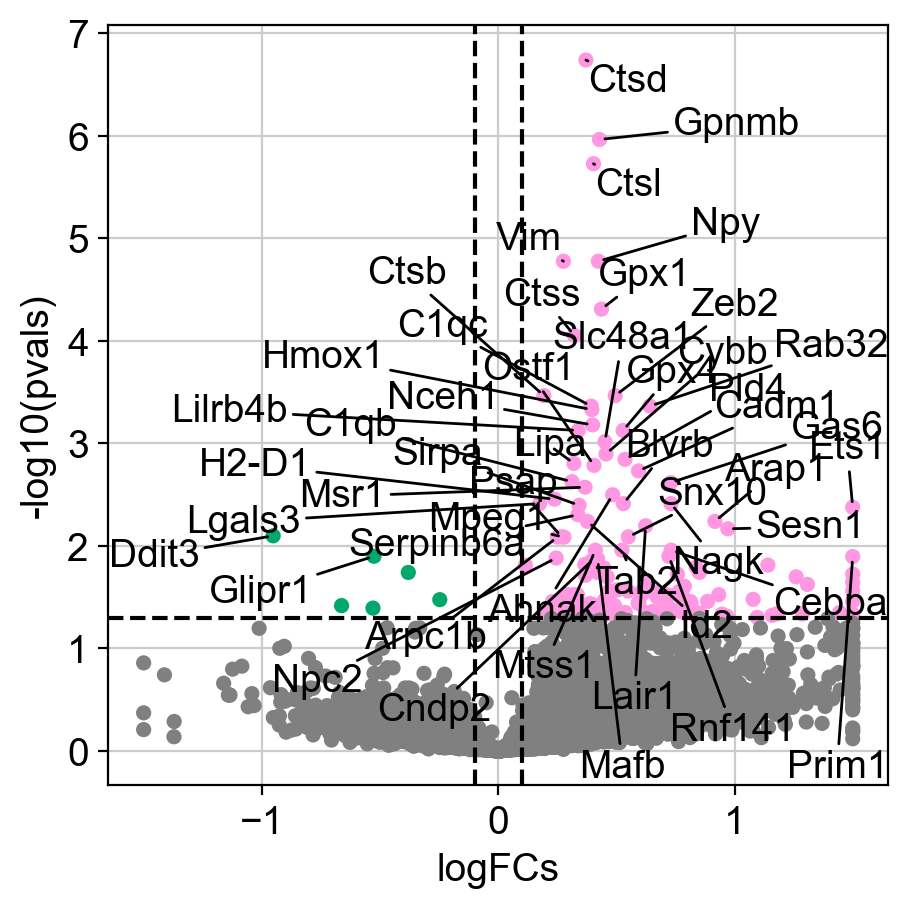

In [42]:
dc.plot_volcano_df(
    volcano_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=50,
    sign_thr=0.05,
    lFCs_thr=0.1,
    figsize=(5, 5),
    color_pos=PHAGO_COLOR,
    color_neg=NONPHAGO_COLOR,
    #save="./figures/volcano.pdf"
)
plt.savefig('combat_figs/combat_volcano_3h.pdf')

In [43]:
volcano_df = df24.copy()
volcano_df.pvals_adj[volcano_df.pvals_adj < 1e-10] = 1e-10
volcano_df.logfoldchanges[volcano_df.logfoldchanges < -1.5] = -1.5
volcano_df.logfoldchanges[volcano_df.logfoldchanges > 1.5] = 1.5

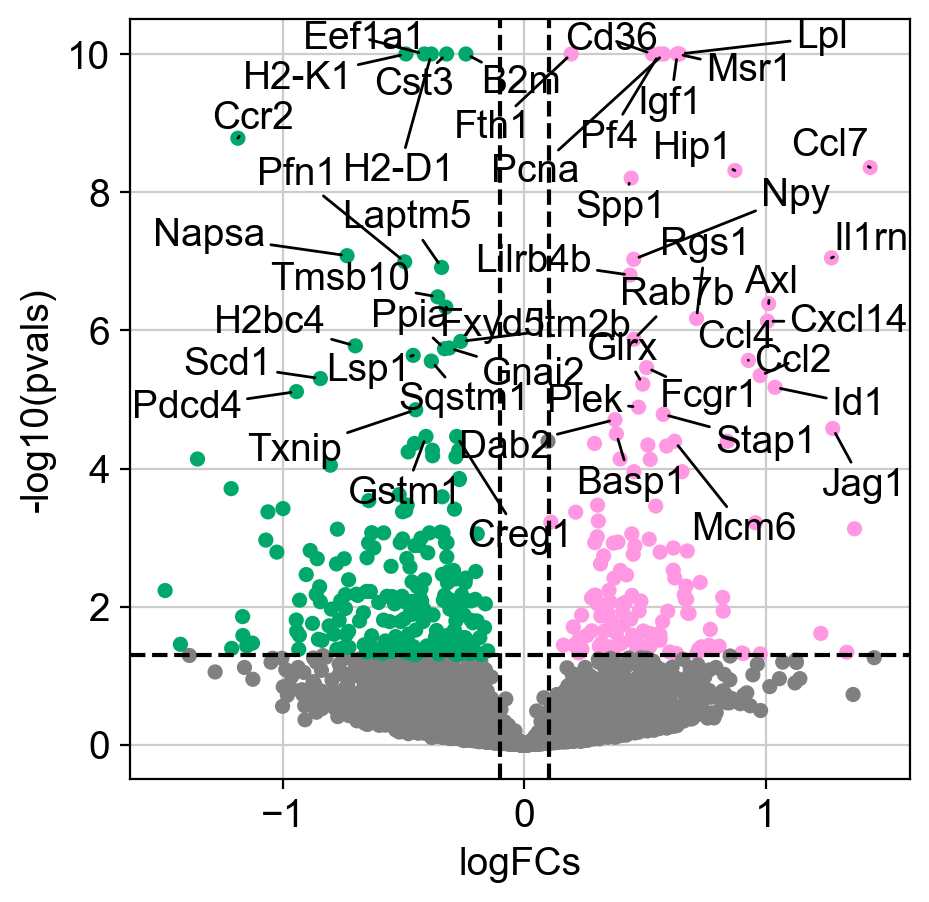

In [ ]:
dc.plot_volcano_df(
    volcano_df,
    x='logfoldchanges',
    y='pvals_adj',
    top=50,
    sign_thr=0.05,
    lFCs_thr=0.1,
    figsize=(5, 5),
    color_pos=PHAGO_COLOR,
    color_neg=NONPHAGO_COLOR,
    #save="./figures/volcano.pdf"
)
plt.savefig('combat_figs/combat_volcano_24h.pdf')

In [46]:
merged = df3.join(df24, lsuffix='_3h', rsuffix='_24h', how='outer')

In [48]:
merged.to_excel('tables/Supp2.xlsx')

# LFC heatmap

In [63]:
genes="""Cdkn1c
Fcgr2b
Bcl3
Sesn1
Arap1
Napsa
Clec4a1
Gpx4
Nfkbia
Pld4
Blvrb
Nagk
Tab2
Marcks
Zeb2
Psmb9
Psap
Samhd1
Sqstm1
H2-K1
H2-D1
H2-T23
Tnfaip1
Hspa5
Spp1
Pcna
Mmd
Ccl3
Azin1
Lpl
Stap1
Hip1
Ccl4
Ccl2""".splitlines()

In [64]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col='Batch.Set.ID',
    groups_col=['Cell_type'],
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000,
    skip_checks=True
)

In [65]:
sc.pp.normalize_total(pdata, target_sum=1e6)
sc.pp.log1p(pdata)

normalizing counts per cell
    finished (0:00:00)


In [66]:
norm_sum_df = pdata.to_df()[genes]
nonphago = norm_sum_df[norm_sum_df.index.str.endswith('non-phago-macs')]
nonphago.index = [i.split("_")[0].split("o-")[1] for i in nonphago.index]
phago = norm_sum_df[norm_sum_df.index.str.endswith('phago')]
phago.index = [i.split("_")[0].split("o-")[1] for i in phago.index]

In [67]:
lfc_per_replicate = np.log2(phago / nonphago)

In [68]:
index_order = ['Cdkn1c', 'Fcgr2b', 'Bcl3', 'Sesn1', 'Arap1', 'Napsa', 'Clec4a1', 'Gpx4', 'Nfkbia', 'Pld4', 'Blvrb', 'Nagk',
               'Tab2', 'Marcks', 'Zeb2', 'Psmb9', 'Psap', 'Samhd1', 'Sqstm1', 
               'H2-K1', 'H2-D1', 'H2-T23',
               'Tnfaip1', 'Hspa5', 'Spp1', 'Pcna', 'Mmd', 'Ccl3', 'Azin1', 'Lpl', 'Stap1', 'Hip1', 'Ccl4', 'Ccl2']

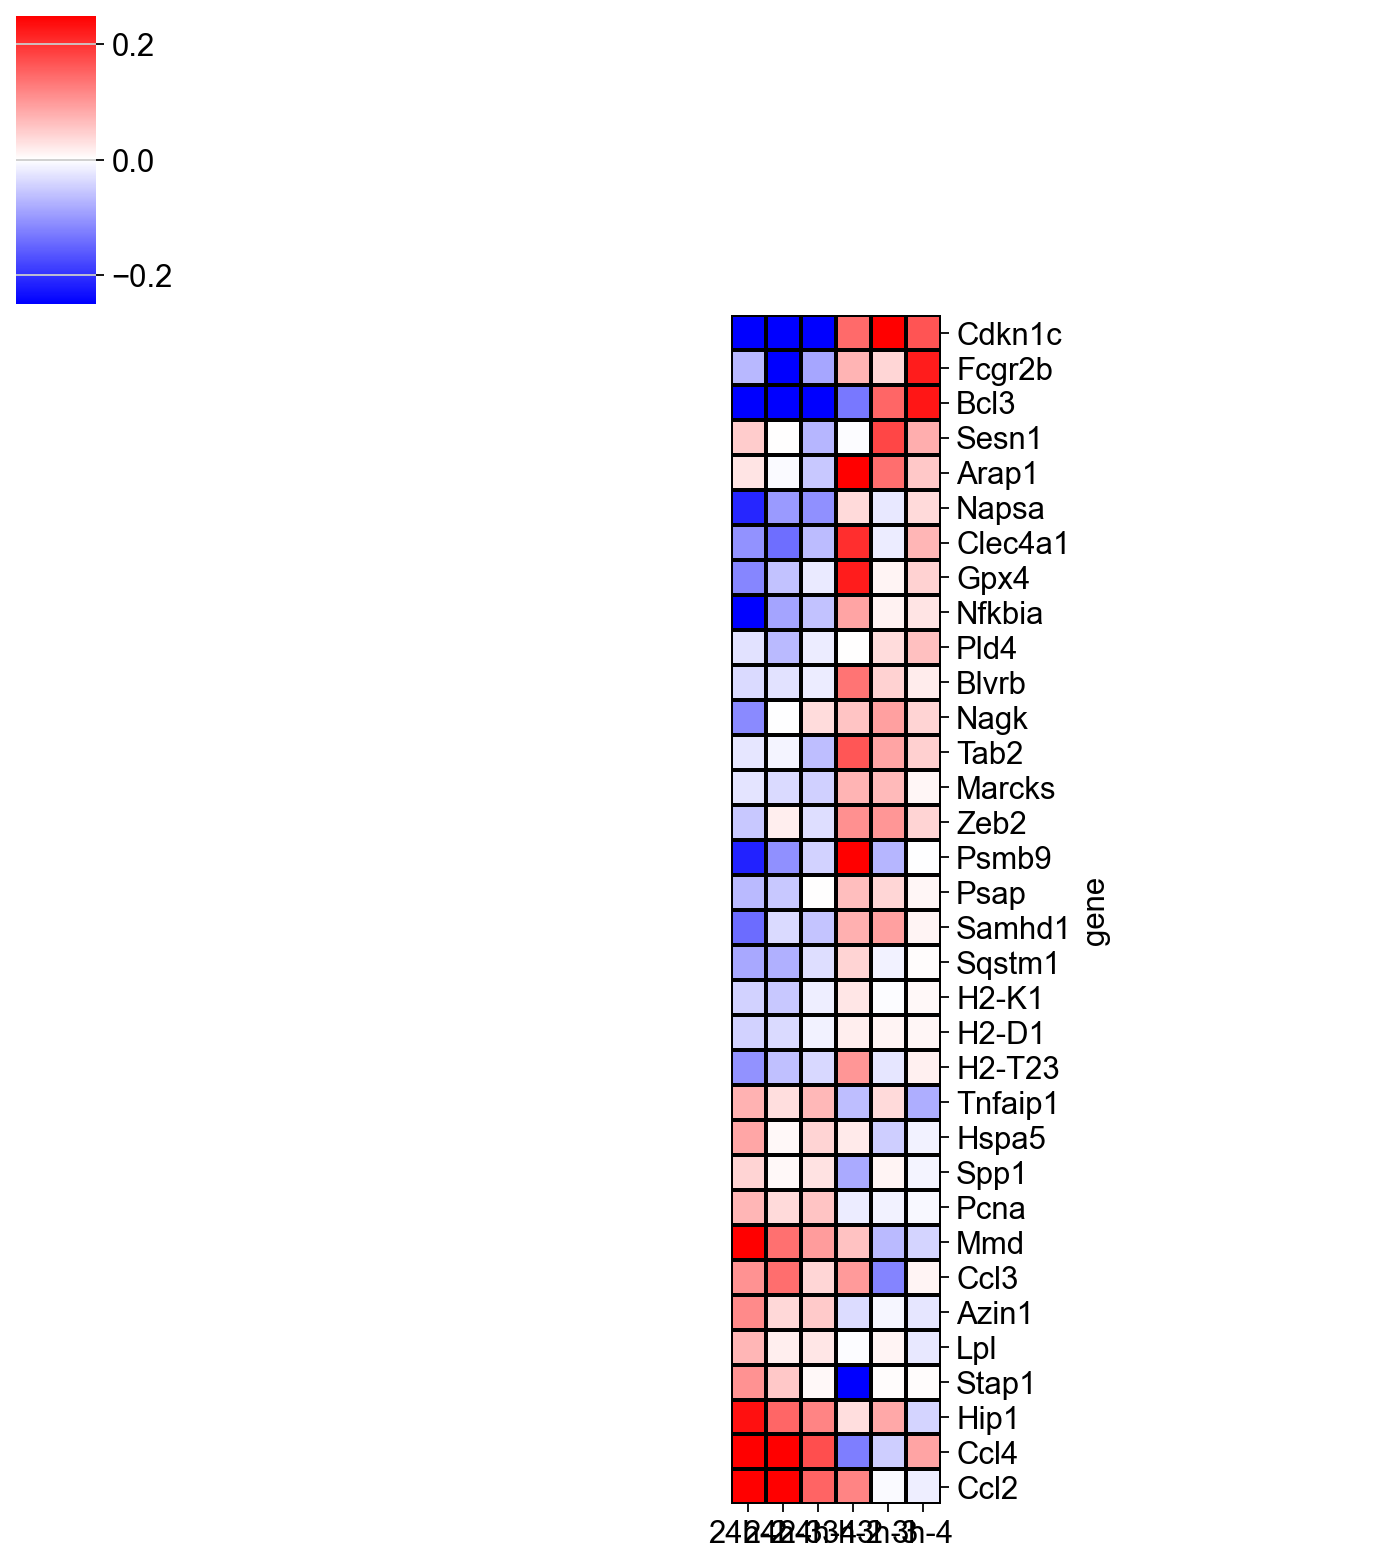

In [ ]:
g = sns.clustermap(lfc_per_replicate[index_order].T, cmap='bwr', center=0, vmin=-0.25, vmax=0.25, 
                   yticklabels=True, col_cluster=False, row_cluster=False, linewidths=1, linecolor='black',)

# Remove gridlines
g.ax_heatmap.grid(False)

# Make each tile square
g.ax_heatmap.set_aspect("equal")

plt.savefig('combat_figs/lfc_per_replicate.pdf')

# pHrodo correlation

In [70]:
cdata = adata[np.isin(adata.obs['Batch.Set.ID'], ['Roi-thymo-3h-3', 'Roi-thymo-3h-4', 
                                                  'Roi-thymo-24h-3', 'Roi-thymo-24h-4'])]
cdata = cdata[cdata.obs.Cell_type == "phago"]

In [71]:
cdata

View of AnnData object with n_obs × n_vars = 3481 × 8425
    obs: 'Amp.Batch.ID', 'Well_position', 'Seq.Batch.ID', 'Date of sequencing', 'Batch.Set.ID', 'Owner', 'Date of sort', 'Plate description', 'Empty_well', 'Species', 'Genome', 'Cell_Line', 'condition', 'Time_point', 'Cell_type', 'comment', 'index', 'Replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'count_scale', 'n_counts', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch.Set.ID_colors', 'Replicate_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Cell_type_colors', 'leiden_colors', 'Time_point_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

In [72]:
cell_dict = {}
for ab in cdata.obs["Amp.Batch.ID"].unique():
    index_df = pd.read_csv("index/" + ab + ".csv", skiprows=9)[['well', '*YG 586/15 - 570LP-A']]
    for well, facs_index in index_df.values:
        cell_dict[ab + "_" + well] = facs_index

In [73]:
ab_sb = cdata.obs[['Amp.Batch.ID', 'Batch.Set.ID']].drop_duplicates().set_index('Amp.Batch.ID').to_dict()['Batch.Set.ID']

In [74]:
scaled_index = pd.DataFrame({'cell': cell_dict.keys(),
                             "batch": [ab_sb[ab.split("_")[0]] for ab in cell_dict.keys()],
                             "FACS_index": cell_dict.values()}).set_index('cell')
scaled_index = scaled_index[scaled_index.index.isin(cdata.obs_names)]

scaled_index['log_FACS_index'] = np.log(scaled_index['FACS_index'])
scaled_index['scaled_index'] = scaled_index.groupby('batch')['log_FACS_index'].transform(lambda x: (x - x.mean()) / x.std())

In [75]:
cdata.obs = pd.concat([cdata.obs, scaled_index.loc[cdata.obs.index, ['FACS_index', 'log_FACS_index', 'scaled_index']]], 
                      axis=1)

In [77]:
bsdata = cdata#[cdata.obs.Time_point == "24"].copy()
gene_df = pd.DataFrame(index=bsdata.var_names,#[bsdata.var.highly_variable], 
                       columns=['pearson_R', 'p_value'])
for g in gene_df.index:
    gene_df.loc[g] = pearsonr(bsdata.obs.scaled_index, bsdata[:,g].X.flatten())

In [78]:
gene_df['p_val_corr'] = fdrcorrection(gene_df.p_value)[1]

In [79]:
gene_df[gene_df.p_val_corr < 0.05].sort_values('pearson_R', ascending=False)

,pearson_R,p_value,p_val_corr
gene,,,
Fth1,0.099679,0.0,0.000032
Ctsb,0.095455,0.0,0.000064
Gas6,0.094554,0.0,0.000064
C1qc,0.087437,0.0,0.000502
Ctsd,0.082374,0.000001,0.001614
Mpeg1,0.081935,0.000001,0.001614
Fabp5,0.081816,0.000001,0.001614
Hpse,0.079639,0.000003,0.00265
Vat1,0.079272,0.000003,0.00265


In [1117]:
corr_gene_list = ['Fth1', 'Ctsb', 'Gas6', 'C1qc', 'Ctsd', 'Mpeg1', 'Fabp5', 'Id2', 'Hmox1', 'Fabp4', 'Lgals3', 'Rhob', 'Rragc', 'Rack1']

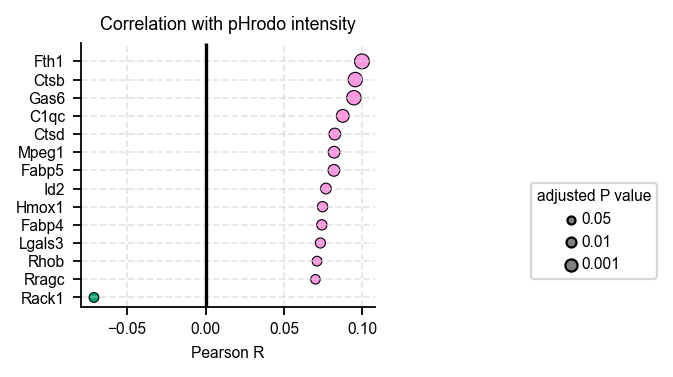

In [ ]:
# Compute -log10(adj_pval) for size mapping
gene_df["neg_log10_adj_pval"] = -np.log10(gene_df["p_val_corr"].astype(float)) * 10

#plogene_df = gene_df[gene_df.p_val_corr < 0.05].sort_values(by='pearson_R').reset_index(names='names')
plogene_df = gene_df.loc[corr_gene_list].sort_values(by='pearson_R').reset_index(names='names')

mm = 0.1/2.54

plt.rcParams.update({
    'font.size': 7,         # Default font size
    'axes.labelsize': 7,    # X and Y axis labels
    'axes.titlesize': 7,    # Title
    'xtick.labelsize': 7,   # X-axis tick labels
    'ytick.labelsize': 7,   # Y-axis tick labels
    'legend.fontsize': 7,   # Legend text
    'figure.titlesize': 7   # Figure title
})


# Create figure
fig, ax = plt.subplots(figsize=(60*mm, 55*mm))
plt.rcParams.update({'font.size': 7})

# Scatter plot with manually mapped colors
scatter = ax.scatter(
    plogene_df['pearson_R'], plogene_df['names'],
    c=[NONPHAGO_COLOR if i < 0 else PHAGO_COLOR for i in plogene_df['pearson_R']], 
    s=plogene_df['neg_log10_adj_pval'], edgecolor='black', linewidths=0.5,
)

# Labels and title
ax.set_xlabel("Pearson R", fontdict={'size': 7})
ax.set_ylabel("")
ax.set_title("Correlation with pHrodo intensity", fontdict={'size': 8})
plt.vlines(0, -1, len(plogene_df), color='black')
ax.set_ylim(-0.5, len(plogene_df))

size_legend_values = np.array([0.05, 0.01, 0.001])  # Example p-values
size_legend_sizes = -np.log10(size_legend_values) * 10  # Convert to plot sizes

legend_handles = [plt.scatter([], [], s=size, edgecolor='black', color='gray', label=pval)
                  for size, pval in zip(size_legend_sizes, size_legend_values)]

plt.legend(handles=legend_handles, title="adjusted P value", loc='upper left', bbox_to_anchor=(1.5, 0.5))

# Grid for readability
ax.grid(True, linestyle="--", alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.savefig('combat_figs/index_corr_dotplot_manual.pdf')


In [87]:
gene_df = gene_df[gene_df.columns[:-1]]
gene_df.columns = ["pHrodo " + col for col in gene_df.columns]

In [89]:
pd.merge(merged, gene_df, left_index=True, right_index=True).to_excel('tables/Supp2_corr.xlsx')